In [1]:
!nvidia-smi

Thu Apr 25 11:46:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:06:00.0 Off |                    0 |
| N/A   30C    P0              42W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Inter-class variance 
- It refers to the variance between the different classes or groups in a dataset. 
- It measures how well the classes or groups are separated from each other. 
- A higher inter-class variance indicates that the classes are more distinct and well-separated.

# Intra-class variance, 
- on the other hand, refers to the variance within each individual class or group. 
- It measures how similar the data points are within the same class. 
- A lower intra-class variance indicates that the data points in a class are more homogeneous and closely clustered together.

# Important Links:

- Link 1: https://math.stackexchange.com/questions/81024/about-the-total-variance-and-the-inter-and-inter-class-variances
- Link 2: https://www.mathworks.com/matlabcentral/fileexchange/64266-inter-class-variance-intra-class-variance-for-segmented-image
- Link 3: https://arxiv.org/abs/2109.11891
- Link 4: https://link.springer.com/chapter/10.1007/978-3-030-87156-7_8
- Link 5: https://en.wikipedia.org/wiki/Intraclass_correlation


In [2]:
import os
import torch
import timm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

# Define the path to your dataset
dataset_root = "/net/polaris/storage/deeplearning/sur_data/binary_rgb_daa/split_0/train"

# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load the pretrained ViT model
model = timm.create_model(
    'vit_huge_patch14_224.orig_in21k',
    pretrained=True,
    num_classes=0,  # Remove classifier nn.Linear
)
model = model.eval()
model = model.to(device)

# Create data transforms
data_config = timm.data.resolve_model_data_config(model)
data_transforms = timm.data.create_transform(**data_config, is_training=False)

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# Set up DataLoader
dataset = ImageFolder(root=dataset_root, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)

# Batch wise Inputs and Features Shape
- torch.Size([1024, 3, 224, 224])
- torch.Size([1024, 1280])

In [11]:
import pickle
# Initialize feature storage with numpy arrays for concatenation
features_by_class = {0: np.empty((0, 1280), dtype=float),  # feature size
                     1: np.empty((0, 1280), dtype=float)}

# Extract features
with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        features = model(inputs)
        features = features.cpu().numpy()  # Convert to NumPy after moving to CPU
        labels = labels.cpu().numpy()

        # Efficiently concatenate features by class
        for class_index in features_by_class.keys():
            class_features = features[labels == class_index]
            features_by_class[class_index] = np.concatenate((features_by_class[class_index], class_features))

# Save the features to a pickle file
with open('/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/notebooks/varience_analysis/Features_binary_split_0_kinect_rgb/features_by_class.pickle', 'wb') as handle:
    pickle.dump(features_by_class, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Features saved successfully.")

100%|██████████| 254/254 [6:38:45<00:00, 94.20s/it]  


Features saved successfully.


In [1]:
import pickle

# Path to the pickle file
pickle_file_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/notebooks/varience_analysis/Features_binary_split_0_kinect_rgb/features_by_class.pickle'

# Load the dictionary from the pickle file
with open(pickle_file_path, 'rb') as handle:
    loaded_features_by_class = pickle.load(handle)

# Print the loaded dictionary to verify its contents
print("Loaded features by class successfully:")
print(loaded_features_by_class)


Loaded features by class successfully:
{0: array([[ 0.04110655, -0.13989964, -0.10817131, ..., -0.04773098,
        -0.12528147,  0.07864159],
       [ 0.01785623, -0.15238588, -0.13102521, ..., -0.05035559,
        -0.12428994,  0.0712035 ],
       [ 0.01438782, -0.13875481, -0.15631329, ..., -0.04806796,
        -0.09027962,  0.07788383],
       ...,
       [ 0.09432463, -0.11035094, -0.09907368, ..., -0.03312398,
        -0.11810396,  0.08119474],
       [ 0.08805221, -0.10931683, -0.10842346, ..., -0.03464087,
        -0.10752042,  0.06914657],
       [ 0.09222632, -0.112335  , -0.09447549, ..., -0.03091649,
        -0.1003587 ,  0.0605195 ]]), 1: array([[ 0.04393481, -0.103698  , -0.1032593 , ..., -0.03917844,
        -0.12058262,  0.05428848],
       [ 0.02594432, -0.1150863 , -0.1046125 , ..., -0.03394674,
        -0.12621248,  0.05163221],
       [ 0.02390348, -0.13141918, -0.08928952, ..., -0.03822639,
        -0.12190837,  0.0541271 ],
       ...,
       [ 0.08722889, -0.1504

In [2]:
# Check and print the length of each entry in the dictionary
for class_name, features in loaded_features_by_class.items():
    print(f"Length of features for class '{class_name}': {len(features)}")

Length of features for class '0': 79934
Length of features for class '1': 179931


In [3]:
first_n_d_feature = loaded_features_by_class[0][0]
len(first_n_d_feature)

1280

In [7]:
loaded_features_by_class[0]

array([[ 0.04110655, -0.13989964, -0.10817131, ..., -0.04773098,
        -0.12528147,  0.07864159],
       [ 0.01785623, -0.15238588, -0.13102521, ..., -0.05035559,
        -0.12428994,  0.0712035 ],
       [ 0.01438782, -0.13875481, -0.15631329, ..., -0.04806796,
        -0.09027962,  0.07788383],
       ...,
       [ 0.09432463, -0.11035094, -0.09907368, ..., -0.03312398,
        -0.11810396,  0.08119474],
       [ 0.08805221, -0.10931683, -0.10842346, ..., -0.03464087,
        -0.10752042,  0.06914657],
       [ 0.09222632, -0.112335  , -0.09447549, ..., -0.03091649,
        -0.1003587 ,  0.0605195 ]])

In [9]:
# Initialize lists to hold keys and values
class_names = []
features_list = []

# Extract keys and values into separate lists
for class_name, features in loaded_features_by_class.items():
    class_names.append(class_name)
    features_list.append(features)

# Intra-class Variance: This is the variance within each class. It measures the spread of the features for each image within the same class.

In [10]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

# Calculate the intra-class variance (WCV)
class_variances = [np.var(features, axis=0) for features in features_list]
intra_class_variance = np.mean(class_variances, axis=0)

In [11]:
len(class_variances)

2

In [12]:
intra_class_variance

array([0.00155631, 0.00193993, 0.00132019, ..., 0.00045461, 0.00100365,
       0.00147615])

In [13]:
len(intra_class_variance)

1280

In [14]:
# Calculate the class centers (means of features for each class)
class_centers = [np.mean(features, axis=0) for features in features_list]

In [15]:
len(class_centers)

2

In [16]:
first_class_center = class_centers[0]
first_class_center

array([ 0.07689248, -0.09305881, -0.10473181, ..., -0.02314278,
       -0.05737143, -0.01066033])

In [17]:
len(first_class_center)

1280

In [ ]:
# Convert class_centers to a NumPy array
class_centers_array = np.array(class_centers)

# Inter-class Variance: This is the variance between the classes. It can be interpreted in terms of the mean features of each class.

# For Feature Space
- Intra-Class Variance measures the variability of feature values within each class individually. 
- It helps you understand how spread out the feature values are for each class. 
- In high-dimensional spaces, this is crucial for understanding the compactness and consistency of feature representations within each class.
- Inter-Class Variance measures the variability between the classes, typically focusing on the differences between the mean feature vectors of each class. 
- This metric is critical for classification tasks as it provides insight into how distinct or separable the classes are in the feature space.

# Approach For Intra-Class Variance:
- Calculate the variance for each feature across all samples within the same class. 
- This results in a variance value for each of the 1280 features, providing a profile of variability for each class.

# For Inter-Class Variance:
- Calculate the mean of each feature for each class and then compute the variance of these means between the two classes. 
- This effectively measures how different the average feature vectors are between the classes.

#  How similar the feature representations are within each class?
- ICC Intra-Class Correlation : implying how consistently the model extracts features for images of the same class.

# When deciding on model adjustments or feature selection
- as high ICC values suggest that the model responds consistently to images within the same class, 
- while low ICC values might indicate that your feature extraction process could be improved for consistency.

In [22]:
# Assuming class0_features and class1_features are numpy arrays with shapes described
class0_features = features_list[0]
class1_features = features_list[1]
print(len(class0_features))
print(len(class1_features))
print(class0_features.shape)
print(class1_features.shape)

79934
179931
(79934, 1280)
(179931, 1280)


# Variances across 1280 Features and their Means

- Data Structure: We have an array class0_features where each row represents the features of an image and there are 1280 features per image (79934 x 1280 array).
- Variance Calculation Across Axis 0: The np.var() function calculates the variance across axis=0, which means it operates along the vertical axis, aggregating over rows for each of the 1280 columns. In simpler terms, for each feature (each column), it computes how much the values of that feature vary among all the images in class 0.
- Result: The output, intra_class_variance_class0, is a 1D array with 1280 elements, each representing the variance of a corresponding feature across all images in class 0. Each value indicates the spread or variability of a single feature across all images, informing us about the consistency of feature extraction within that class.

- When calculating the inter-class variance, we first compute the means of each feature for both classes:
- The results are two 1D arrays (mean_class0 and mean_class1), each with 1280 elements where each element is the average value of a feature across all images in a class.
- Next, we calculate the variance between these mean values.

In [24]:
import numpy as np

# Intra-Class Variance
intra_class_variance_class0 = np.var(class0_features, axis=0)
intra_class_variance_class1 = np.var(class1_features, axis=0)

# Inter-Class Variance (between class features means)
mean_class0 = np.mean(class0_features, axis=0)
mean_class1 = np.mean(class1_features, axis=0)
inter_class_variance = np.var([mean_class0, mean_class1], axis=0)

print("Intra-Class Variance for Class 0:", intra_class_variance_class0)
print("Intra-Class Variance for Class 1:", intra_class_variance_class1)
print("Inter-Class Variance:", inter_class_variance)


Intra-Class Variance for Class 0: [0.00138526 0.001618   0.0009892  ... 0.00033188 0.00069753 0.00115076]
Intra-Class Variance for Class 1: [0.00172737 0.00226186 0.00165118 ... 0.00057734 0.00130977 0.00180154]
Inter-Class Variance: [2.60337538e-05 1.13607180e-05 1.52251882e-08 ... 3.52239505e-07
 6.01917735e-07 2.85083656e-06]


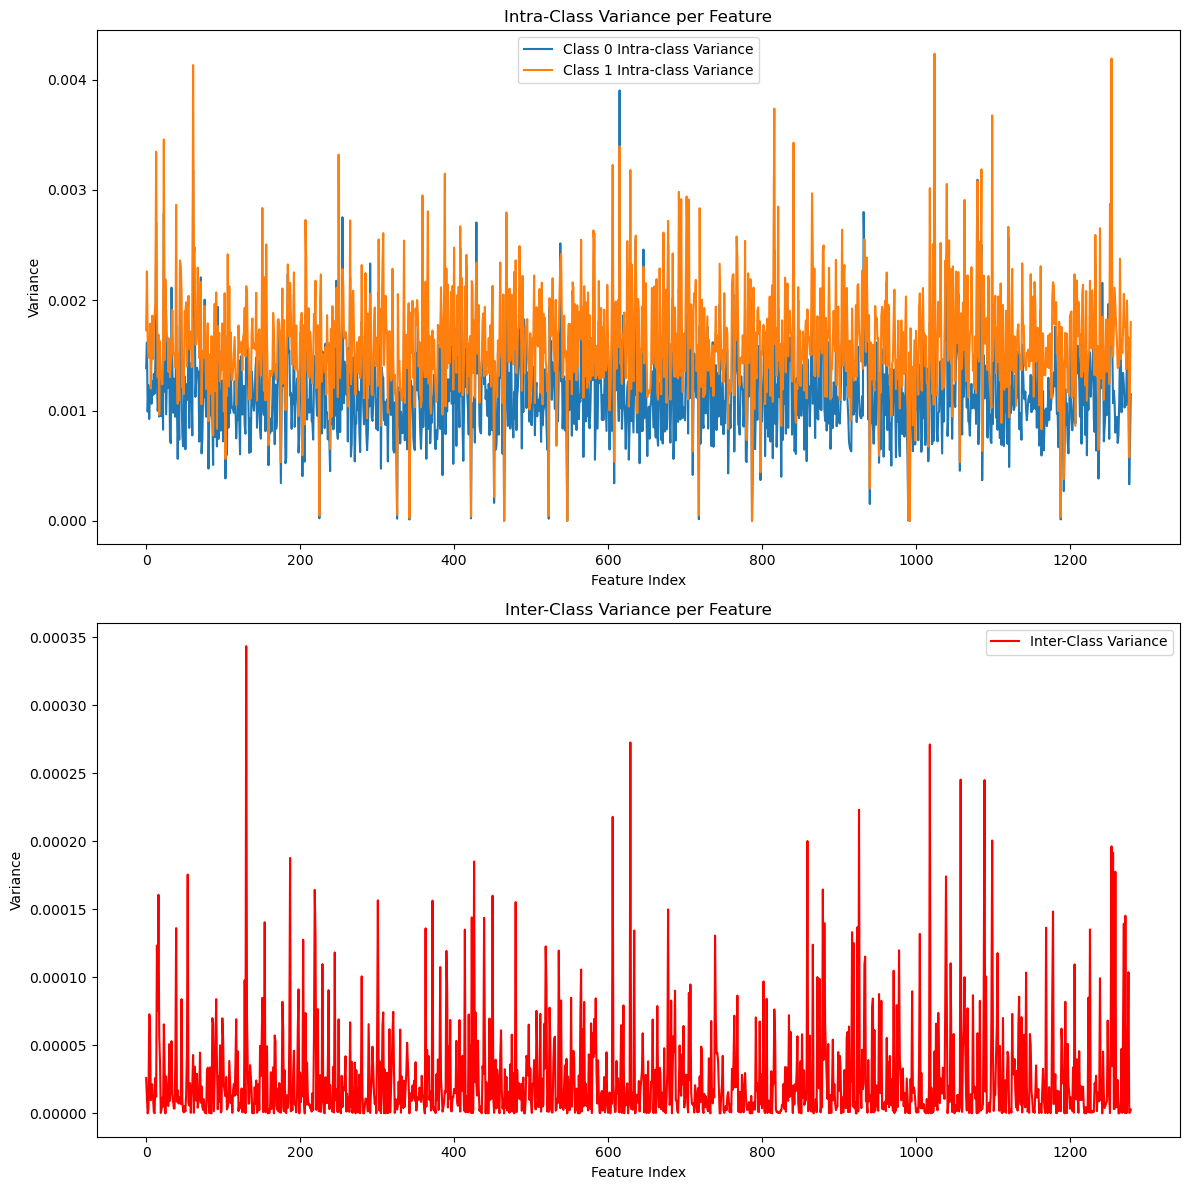

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_variances(intra_class_var0, intra_class_var1, inter_class_var):
    # Number of features
    features = np.arange(len(intra_class_var0))

    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))

    # Plot intra-class variances
    ax[0].plot(features, intra_class_var0, label='Class 0 Intra-class Variance')
    ax[0].plot(features, intra_class_var1, label='Class 1 Intra-class Variance')
    ax[0].set_title('Intra-Class Variance per Feature')
    ax[0].set_xlabel('Feature Index')
    ax[0].set_ylabel('Variance')
    ax[0].legend()

    # Plot inter-class variance
    ax[1].plot(features, inter_class_var, color='red', label='Inter-Class Variance')
    ax[1].set_title('Inter-Class Variance per Feature')
    ax[1].set_xlabel('Feature Index')
    ax[1].set_ylabel('Variance')
    ax[1].legend()

    # Enhance layout
    plt.tight_layout()
    plt.show()

plot_variances(intra_class_variance_class0, intra_class_variance_class1, inter_class_variance)


# Plot Analysis:

# Intra-Class Variance Plot (Top Plot):
- The variances for each feature within both classes are overlapping and spread across a similar range. 
- There's no clear pattern of one class having consistently higher or lower variance than the other, which indicates that within each class, the features have a similar degree of spread.

- The overall level of intra-class variance is relatively low (note the scale on the y-axis), which may suggest that the features are fairly consistent within each class.

# Inter-Class Variance Plot (Bottom Plot):
- The inter-class variance has several peaks, indicating that there are specific features where the mean values between the two classes differ significantly.
- The presence of high peaks in inter-class variance can be useful for classification purposes, as these features may be particularly good at distinguishing between the two classes.

# Conclusions from the Plots:
- Consistency: Both classes exhibit a degree of consistency within themselves as indicated by the intra-class variance levels, which could suggest that the features are stable within each class.
- Distinguishability: The inter-class variance indicates that certain features are indeed different between the two classes, which can be exploited for classification tasks.
- Feature Selection: The features corresponding to the peaks in the inter-class variance plot are candidates for feature selection. These features could potentially improve the performance of a classifier as they have a higher discriminative power.
- Noise and Redundancy: Features with low inter-class variance and high intra-class variance might be considered noisy or less useful for classification and could be candidates for removal to improve model performance and reduce overfitting.

In [25]:
print("The length of intra class variance for class 0 is:", len(intra_class_variance_class0))
print("The length of intra class variance for class 1 is:", len(intra_class_variance_class1))
print("The length of inter class variance is:", len(inter_class_variance))

The length of intra class variance for class 0 is: 1280
The length of intra class variance for class 1 is: 1280
The length of inter class variance is: 1280


- To check whether the intra-class variance is smaller than both the minimum distance and the mean distance between class centers, we'll follow these steps:

- Calculate the Class Centers: Compute the mean feature vector for each class, which represents the center of that class in the feature space.
- Calculate Distances Between Class Centers:
- Minimum Distance: The shortest distance between the two class centers.
- Mean Distance: Compute the average distance between the centers using all features.
- Compare Intra-Class Variance to Distances: Check whether the intra-class variance for each feature is less than both the minimum and the mean distances between the class centers.
- Visualize: Plot the comparison to visually inspect how the intra-class variance relates to the distances between class centers.

The minimum distance between feature class centers 4.778815981487661e-06
The minimum distance between feature class centers 0.008146759312479861


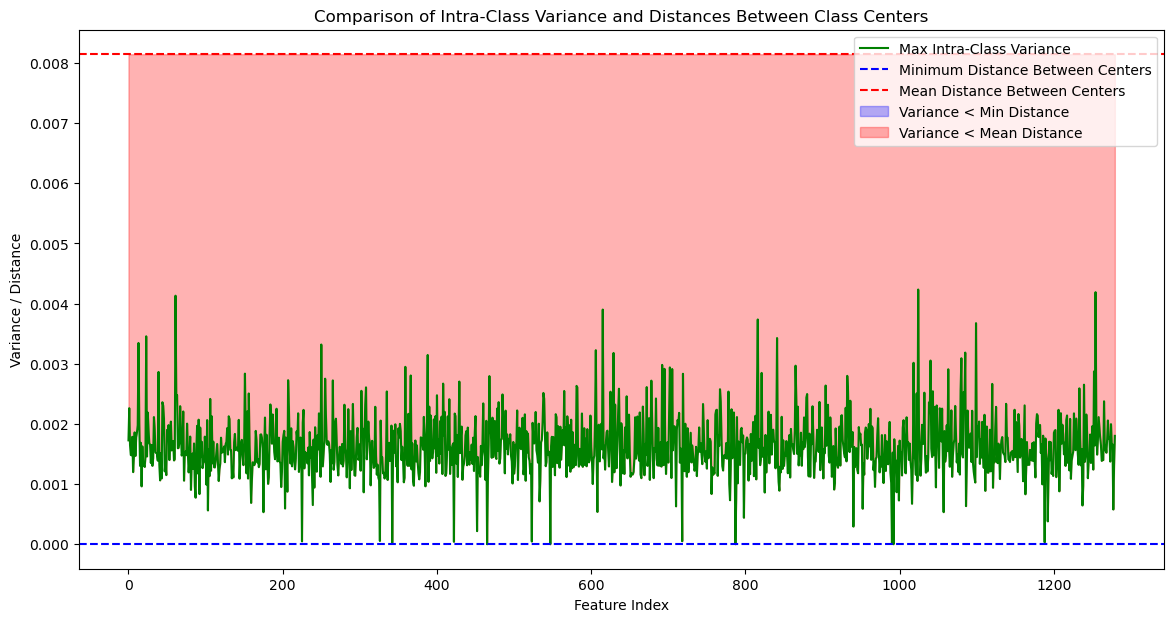

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the class centers (mean vectors)
center_class0 = np.mean(class0_features, axis=0)
center_class1 = np.mean(class1_features, axis=0)

# Calculate minimum and mean distance between class centers or feature class centers
min_distance = np.min(np.abs(center_class0 - center_class1))
mean_distance = np.mean(np.abs(center_class0 - center_class1))

print('The minimum distance between feature class centers', min_distance)
print('The minimum distance between feature class centers', mean_distance)

# Calculate intra-class variances
# intra_class_variance_class0 = np.var(class0_features, axis=0)
# intra_class_variance_class1 = np.var(class1_features, axis=0)

# Find the maximum intra-class variance between the two classes for each feature
max_intra_class_variance = np.maximum(intra_class_variance_class0, intra_class_variance_class1)

# Check if intra-class variance is smaller than both minimum and mean distances
variance_smaller_than_min = max_intra_class_variance < min_distance
variance_smaller_than_mean = max_intra_class_variance < mean_distance


# Visualization
features = np.arange(len(max_intra_class_variance))
plt.figure(figsize=(14, 7))

plt.plot(features, max_intra_class_variance, label='Max Intra-Class Variance', color='green')
plt.axhline(y=min_distance, label='Minimum Distance Between Centers', color='blue', linestyle='--')
plt.axhline(y=mean_distance, label='Mean Distance Between Centers', color='red', linestyle='--')

plt.fill_between(features, max_intra_class_variance, min_distance, where=variance_smaller_than_min, color='blue', alpha=0.3, label='Variance < Min Distance')
plt.fill_between(features, max_intra_class_variance, mean_distance, where=variance_smaller_than_mean, color='red', alpha=0.3, label='Variance < Mean Distance')

plt.title('Comparison of Intra-Class Variance and Distances Between Class Centers')
plt.xlabel('Feature Index')
plt.ylabel('Variance / Distance')
plt.legend()
plt.show()



This plot represent a comparison between intra-class variance and distances between class centers for a number of features in a dataset. Here's an analysis of the information presented:

- Max Intra-Class Variance: This is the highest variance observed within any class across all features. It's marked with a dashed red horizontal line at the top of the plot.
- Minimum Distance Between Centers: This dashed blue horizontal line represents the smallest distance between the centers of any two classes across all features. Ideally, for well-separated classes, this value should be high.
- Mean Distance Between Centers: Represented by the dashed purple horizontal line, this is the average distance between the centers of all classes. A higher mean distance usually indicates better class separation.
- Variance < Min Distance: The light blue shaded area indicates the regions where the feature variance is less than the minimum distance between class centers. This suggests that the classes are well-separated for those features.
- Variance < Mean Distance: The pink shaded area shows where the feature variance is less than the mean distance between class centers. It is larger than the light blue area, indicating that more features have a variance less than the mean distance as opposed to the minimum distance.
- Individual Feature Variance: The green line graph shows the intra-class variance for each feature. The individual peaks represent the variance within classes for that feature. The closer these peaks are to zero, the less overlap there is within the classes for that feature.

Based on this plot, if we see a significant amount of green variance lines below both the minimum and mean distance lines (i.e., in the shaded areas), it can be inferred that for a large number of features, the within-class variability is less than the between-class distances. This suggests that the model is capable of extracting features that differentiate between classes well, which is desirable for classification tasks.

However, if many of the green variance lines are above the blue and purple dashed lines, or if the shaded areas are very small or non-existent, this would indicate poor class separation for those features, suggesting that the model might not be extracting features that adequately distinguish between classes.

In the plot above, most of the green variance lines appear to be below the dashed lines for the mean distances between centers, and there is a substantial shaded area (especially in pink). This suggests that, on average, the features are being extracted well, with a low within-class variance and a relatively high between-class distance. This would generally be indicative of a model that can effectively discriminate between classes, which is typically what you want in a classification scenario.

- Intra-Class Variance vs. Minimum Distance: The maximum intra-class variance (green line) is consistently above the minimum distance between the class centers (blue dashed line). This indicates that even the features with the highest variance within each class are still closer to their own class center than to the other class center.

- Intra-Class Variance vs. Mean Distance: The maximum intra-class variance is also well below the mean distance between class centers (red dashed line), which suggests a good level of separation between classes.

- Coverage: The shaded areas (blue for minimum distance and red for mean distance) indicate the proportion of the feature space where the maximum intra-class variance is smaller than the respective distances. The entire feature space is shaded, which suggests that this condition holds true for all features.

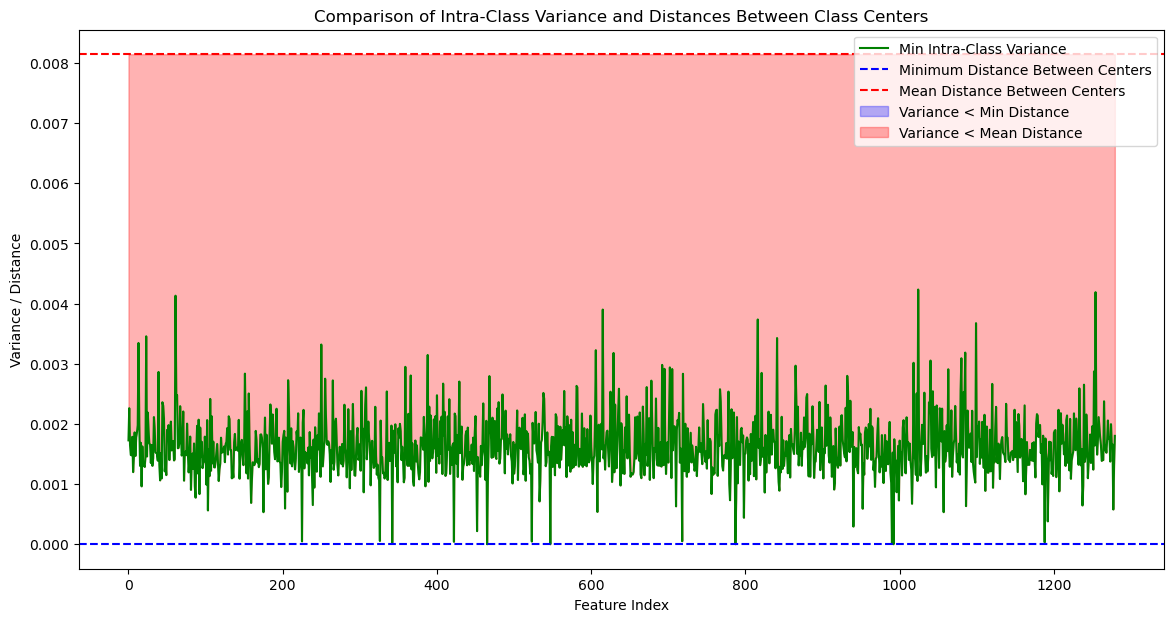

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the class centers (mean vectors)
center_class0 = np.mean(class0_features, axis=0)
center_class1 = np.mean(class1_features, axis=0)

# Calculate minimum and mean distance between class centers or feature class centers
min_distance = np.min(np.abs(center_class0 - center_class1))
mean_distance = np.mean(np.abs(center_class0 - center_class1))

# Calculate intra-class variances
# intra_class_variance_class0 = np.var(class0_features, axis=0)
# intra_class_variance_class1 = np.var(class1_features, axis=0)

# Find the minimum intra-class variance between the two classes for each feature
min_intra_class_variance = np.minimum(intra_class_variance_class0, intra_class_variance_class1)

# Check if intra-class variance is smaller than both minimum and mean distances
variance_smaller_than_min = min_intra_class_variance < min_distance
variance_smaller_than_mean = min_intra_class_variance < mean_distance

# Visualization
features = np.arange(len(max_intra_class_variance))
plt.figure(figsize=(14, 7))

plt.plot(features, max_intra_class_variance, label='Min Intra-Class Variance', color='green')
plt.axhline(y=min_distance, label='Minimum Distance Between Centers', color='blue', linestyle='--')
plt.axhline(y=mean_distance, label='Mean Distance Between Centers', color='red', linestyle='--')

plt.fill_between(features, max_intra_class_variance, min_distance, where=variance_smaller_than_min, color='blue', alpha=0.3, label='Variance < Min Distance')
plt.fill_between(features, max_intra_class_variance, mean_distance, where=variance_smaller_than_mean, color='red', alpha=0.3, label='Variance < Mean Distance')

plt.title('Comparison of Intra-Class Variance and Distances Between Class Centers')
plt.xlabel('Feature Index')
plt.ylabel('Variance / Distance')
plt.legend()
plt.show()
